In [10]:
import numpy as np
import pandas as pd
from plot_keras_history import show_history, plot_history
from keras.preprocessing.image import ImageDataGenerator
import os
import random 
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

In [4]:
dir = r"D:\Handwriting OCR\dataset2\Train"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

In [5]:
def p_m(history, num_epochs):
   accuracy = history.history['accuracy']
   precision = history.history['precision']
   recall = history.history['recall']
   auc = history.history['auc']
   i = num_epochs-1
   performance_metrics = [accuracy[i], precision[i], recall[i], auc[i]]
   print(performance_metrics)
   plot_history(history, path="standard.png")
   return performance_metrics

In [6]:
val_dir = r"D:\Handwriting OCR\dataset2\Validation"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

In [7]:
len(train_data)
len(val_data)

18104

In [8]:
random.shuffle(train_data)
random.shuffle(val_data)

In [9]:
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [10]:
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [11]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)

In [12]:
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [13]:
print(train_X.shape,val_X.shape)

(140000, 32, 32, 1) (18104, 32, 32, 1)


In [14]:
print(train_Y.shape,val_Y.shape)

(140000, 35) (18104, 35)


# ANN Model

In [18]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import models
from keras import layers
import tensorflow as tf

In [ ]:
optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.99)
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_acc',verbose=2,factor=0.5,min_lr=0.00001)
callback=[EarlyStop , Reduce_LR]

In [37]:
def ANN():
    # create model
    model = Sequential()
    model.add(Conv2D(256, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Dense(32, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Dense(8, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(35, activation='softmax'))
    
    # compile model
    adam = Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy','Precision','Recall','AUC'])
    return model

ANN_model = ANN()

print(ANN_model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 256)       2560      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 256)      0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 256)       0         
                                                                 
 dense_10 (Dense)            (None, 16, 16, 32)        8224      
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                

c:\Users\risha\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [38]:
import torch
torch.cuda.is_available()

False

In [39]:
ANN_history1 = ANN_model.fit(train_X,train_Y, epochs=50, batch_size=32, validation_data = (val_X, val_Y),  verbose=1)

Epoch 1/50
9646/9646 [==============================] - 1074s 111ms/step - loss: 0.5719 - accuracy: 0.8255 - precision: 0.8832 - recall: 0.7803 - auc: 0.9908 - val_loss: 0.5091 - val_accuracy: 0.8621 - val_precision: 0.8944 - val_recall: 0.8346 - val_auc: 0.9904
Epoch 2/50
9646/9646 [==============================] - 1004s 104ms/step - loss: 0.3590 - accuracy: 0.8876 - precision: 0.9146 - recall: 0.8647 - auc: 0.9951 - val_loss: 0.4518 - val_accuracy: 0.8766 - val_precision: 0.9033 - val_recall: 0.8517 - val_auc: 0.9916
Epoch 3/50
9646/9646 [==============================] - 979s 102ms/step - loss: 0.3334 - accuracy: 0.8939 - precision: 0.9189 - recall: 0.8732 - auc: 0.9956 - val_loss: 0.4373 - val_accuracy: 0.8769 - val_precision: 0.9067 - val_recall: 0.8500 - val_auc: 0.9924
Epoch 4/50
9646/9646 [==============================] - 1033s 107ms/step - loss: 0.3241 - accuracy: 0.8971 - precision: 0.9216 - recall: 0.8767 - auc: 0.9957 - val_loss: 0.4081 - val_accuracy: 0.8790 - val_precis

[0.8813217282295227, 0.9074541330337524, 0.8600554466247559, 0.9938973784446716]


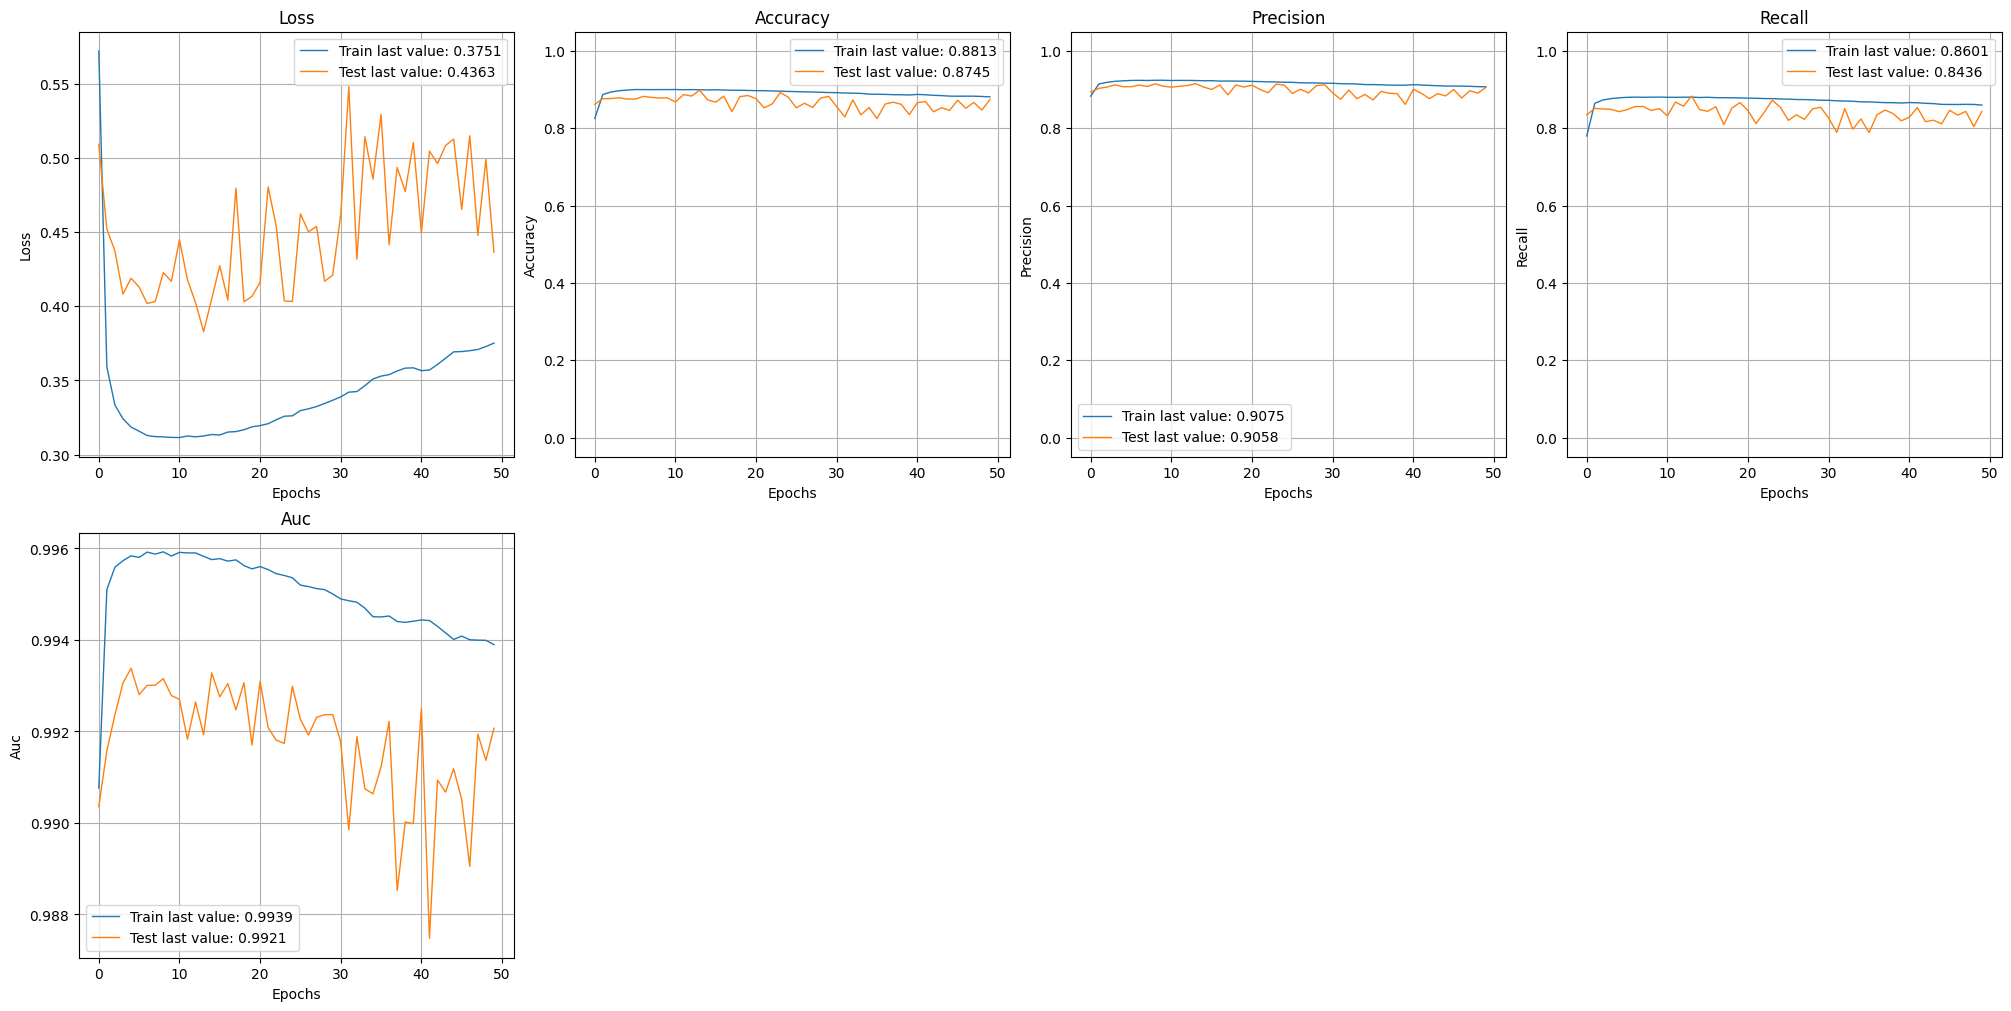

In [40]:
pref = p_m(ANN_history1,50)

In [41]:
ANN_model.save("ANN_handwriting_det_model.hdf5")

In [19]:
from keras.models import load_model
model = load_model("handwriting_det_model.hdf5")

## Recognition Part


In [2]:
%%capture
import cv2
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

In [5]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

def predict(img_path):
    image = Image.open(img_path).convert("RGB")
    print("The Image selected is displayed below :")
    display(image)
    pixel_values = processor(image, return_tensors="pt").pixel_values
    predict_ids = model.generate(pixel_values)
    predicted_text = processor.batch_decode(predict_ids, skip_special_tokens=True)[0]
    print("Predicted Text : ",predicted_text)

def get_word(letter):
    word = "".join(letter)
    return word

In [6]:
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 15:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image


The Image selected is displayed below :


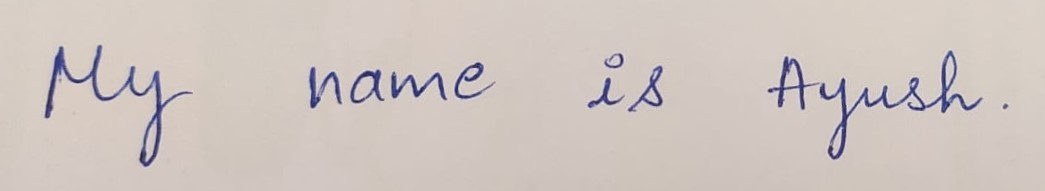

Predicted Text :  My name is Ayush.


In [8]:
predict(r"D:\Handwriting OCR\t.jpg")